<a href="https://colab.research.google.com/github/ydecastro/tensor-spacing/blob/main/spacing_tensors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# t-Spacing test for tensors: the 3-way 2-dimensional case
## Low rank tensors
This jupyter notebook illustrates how to test the existence of **low-rank tensors** in a noisy observation $\bf Y$. The rank one alternative hypothesis is given by:

$$ \mathbf{Y} = \mathbf{W} + \lambda_0 \mathbf{t_0}^{\otimes 3}\,,$$

where $\mathbf{W}\in\mathbb R^{3\times 3\times 3}$ is a symmetric centered Gaussian 3-way tensor, $\lambda_0>0$ an eigenvalue, $\mathbf{t_0}\in\mathbb S^{2}$ an eigenvector. The idea is to compute the **spacing** between the first $\lambda_1$ and second $\lambda_2$ *eigenvalues* of $\bf Y$.

Our procedure is **NOT** specific to detect low rank structure, it is valid for **ALL** alternatives, **BUT** it is thought to be powerfull under low rank alternatives.

## Reference
This notebook is based on the article:
> Azaïs J.-M., Dalmao F., De Castro Y., *TBD*, arXiv:.

and extracted from the GitHub repository:
> [Tensor Spacing on GitHub](https://github.com/ydecastro/tensor-spacing)

# Low-rank tensors: statistical model and analysis

## Introduction

We star by importing some rather standard Python librairies.

In [1]:
# statistics toolbox: normal, student and chi2 laws
from scipy.stats import norm, t, chi2

# Gamma function
from scipy.special import gamma

# numpy with autograd (automatic differentiation) -- autgorad is not really necessary here, look at grad_X function.
import autograd.numpy as np
from autograd import elementwise_grad as egrad


# seaborn for nice displays
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import cm

# progress bar
from tqdm import tqdm

# inline plots
%matplotlib inline

# Figure resolution
sb.set(rc={"figure.dpi":300})

# some useful functions
def cdf_dist_null(z):
    # compute normalized distance between points u and v from the scalar product
    # z=<u,v>
    # 0 means that u = v
    # 1 means that u = -v
    # 1/2 means that u and v are othogonal
    primitive = (1-z)/2
    return primitive

def scalar_prod(u,v):
    return np.dot(np.transpose(u),v)

def color_val(val):
    # fcolors values are used to display a color map on the sphere
    # fcolors are between -1 and 1
    # fcolors = 0 corresponds to the zero level set of the random field
    min_val = np.min(val)
    max_val = np.max(val)
    val_pos = (np.where(val>0, val, 0)/max_val)
    val_neg = (np.where(val<0, val, 0)/(-min_val))
    fcolors = val_neg+val_pos
    return fcolors

The space of $3$-way symmetric tensors of dimension $3$ has dimension $m=10$ ($3$ principal diagonal terms, $6$ sub-diagonals terms, and $1$ off-diagonal term). The noise tensor $\bf W$ is given by
$$
\begin{align*}
W_{iii} &\text{ of variance } \sigma^2\,; \text{ there are } 3 \text{ principal diagonal terms}, i\in[3] \\
 W_{iij} &\text{ of variance } \sigma^2/3\,;\text{ there are } 6 \text{ sub-diagonals terms}, i\neq j\in[3]\\
W_{123} &\text{ of variance } \sigma^2/6\,;\text{ there is }  1 \text{ off-diagonal term},
\end{align*}
$$
where $\sigma>0$ is the standard deviation of the noise.

The eigenvectors $t\in\mathbb S^2$ are vectors of dimension $3$ and unit Euclidean norm, *i.e.,* points of the $2$-Sphere. As we will see, the esitmation of the variance $\sigma^2$ will be done on $\bar m =7$ degrees of freedom.

In [2]:
# dimension of the 2-Sphere
d=2;

# dimension of the 3-way symmetric tensors
m=10;

# degrees of freedom of Spacing test
m_bar=7;

# usefull distributions (student)
rv = t(m-1)
rv2= t(m-3)

## One instance
### Rank one alternatives

We are given a random symmetric tensor $\mathbf{Y}$ such that
$$\mathbb E[\mathbf{Y}]=\lambda_0 \mathbf{t_0}^{\otimes 3}$$

In [3]:
# alternative
lambda_0 = 0
x_0 = 0
y_0 = 0
z_0 = 1
t_0 = np.array([x_0,y_0,z_0]) #eigenvector

Grid sphere

In [4]:
# Grid on the sphere with 'res' points
res = 1024 #recommended 512

# angles of the mesh
phi = np.linspace(0, np.pi, res)
theta = np.linspace(0, 2*np.pi, res)
phi, theta = np.meshgrid(phi, theta)

# The Cartesian coordinates of the unit sphere
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

# Gradient descent parameters to find the maximum of the Random Field
step_size = 0.1
step_count = 512

In [5]:
# Seed for reproducibility
np.random.seed(seed=3141)

# Gaussian vector
r = norm.rvs(size=m);

# Gaussian tensor
W = np.ones(27).reshape((3,3,3));

# diagonal
# principal
W[0,0,0]=r[0]+lambda_0*x_0*x_0*x_0;
W[1,1,1]=r[1]+lambda_0*y_0*y_0*y_0;
W[2,2,2]=r[2]+lambda_0*z_0*z_0*z_0;
# sub-diag
W[0,0,1]=r[3]/np.sqrt(3)+lambda_0*x_0*x_0*y_0;
W[0,1,0]=r[3]/np.sqrt(3)+lambda_0*x_0*x_0*y_0;
W[1,0,0]=r[3]/np.sqrt(3)+lambda_0*x_0*x_0*y_0;
W[0,0,2]=r[4]/np.sqrt(3)+lambda_0*x_0*x_0*z_0;
W[0,2,0]=r[4]/np.sqrt(3)+lambda_0*x_0*x_0*z_0;
W[2,0,0]=r[4]/np.sqrt(3)+lambda_0*x_0*x_0*z_0;
W[1,1,0]=r[5]/np.sqrt(3)+lambda_0*y_0*y_0*x_0;
W[1,0,1]=r[5]/np.sqrt(3)+lambda_0*y_0*y_0*x_0;
W[0,1,1]=r[5]/np.sqrt(3)+lambda_0*y_0*y_0*x_0;
W[1,1,2]=r[6]/np.sqrt(3)+lambda_0*y_0*y_0*z_0;
W[1,2,1]=r[6]/np.sqrt(3)+lambda_0*y_0*y_0*z_0;
W[2,1,1]=r[6]/np.sqrt(3)+lambda_0*y_0*y_0*z_0;
W[2,2,0]=r[7]/np.sqrt(3)+lambda_0*z_0*z_0*x_0;
W[2,0,2]=r[7]/np.sqrt(3)+lambda_0*z_0*z_0*x_0;
W[0,2,2]=r[7]/np.sqrt(3)+lambda_0*z_0*z_0*x_0;
W[2,2,1]=r[8]/np.sqrt(3)+lambda_0*z_0*z_0*y_0;
W[2,1,2]=r[8]/np.sqrt(3)+lambda_0*z_0*z_0*y_0;
W[1,2,2]=r[8]/np.sqrt(3)+lambda_0*z_0*z_0*y_0;
# off-diag
W[0,1,2]=r[9]/np.sqrt(6)+lambda_0*x_0*y_0*z_0;
W[0,2,1]=r[9]/np.sqrt(6)+lambda_0*x_0*y_0*z_0;
W[1,0,2]=r[9]/np.sqrt(6)+lambda_0*x_0*y_0*z_0;
W[1,2,0]=r[9]/np.sqrt(6)+lambda_0*x_0*y_0*z_0;
W[2,1,0]=r[9]/np.sqrt(6)+lambda_0*x_0*y_0*z_0;
W[2,0,1]=r[9]/np.sqrt(6)+lambda_0*x_0*y_0*z_0;
# values of the grid
val =   W[0,0,0]*(x**3) + W[1,1,1]*(y**3) + W[2,2,2]*(z**3)
val +=  6*W[0,1,2]*(x*y*z)
val +=  3*(W[0,0,1]*(x**2*y) + W[0,0,2]*(x**2*z) + W[1,1,0]*(y**2*x) + W[1,1,2]*(y**2*z) + W[2,2,0]*(z**2*x) + W[2,2,1]*(z**2*y))
# maximum on the grid
ind = np.unravel_index(np.argmax(val, axis=None), val.shape)
t_1 = np.array([np.sin(phi[ind]) * np.cos(theta[ind]), np.sin(phi[ind]) * np.sin(theta[ind]), np.cos(phi[ind])]).reshape((3,1))
t_1_grid = t_1
# Random Field X
def X(t):
    X_val = W[0,0,0]*(t[0]**3) + W[1,1,1]*(t[1]**3) + W[2,2,2]*(t[2]**3);
    X_val += 6*W[0,1,2]*(t[0]*t[1]*t[2]);
    X_val += 3*(W[0,0,1]*(t[0]**2*t[1]) + W[0,0,2]*(t[0]**2*t[2]) + W[1,1,0]*(t[1]**2*t[0]) + W[1,1,2]*(t[1]**2*t[2]) + W[2,2,0]*(t[2]**2*t[0]) + W[2,2,1]*(t[2]**2*t[1]));
    return X_val

def grad_X(t):
    gradient_val = np.zeros(3)
    gradient_val[0] = 6*(W[0,1,2]*t[1]*t[2]+W[0,0,2]*t[0]*t[2]+W[0,0,1]*t[0]*t[1]) + 3*(W[0,0,0]*t[0]**2+W[0,1,1]*t[1]**2+W[0,2,2]*t[2]**2)
    gradient_val[1] = 6*(W[1,1,2]*t[1]*t[2]+W[1,0,2]*t[0]*t[2]+W[1,0,1]*t[0]*t[1]) + 3*(W[1,0,0]*t[0]**2+W[1,1,1]*t[1]**2+W[1,2,2]*t[2]**2)
    gradient_val[2] = 6*(W[2,1,2]*t[1]*t[2]+W[2,0,2]*t[0]*t[2]+W[2,0,1]*t[0]*t[1]) + 3*(W[2,0,0]*t[0]**2+W[2,1,1]*t[1]**2+W[2,2,2]*t[2]**2)
    return gradient_val

def grad_riem_X(t):
    Pi = np.dot(t,np.transpose(t))
    temp = np.dot((np.eye(3)-Pi),grad_X(t))
    return temp

egrad_X = egrad(X)

def Hess_X(t):
    H = np.zeros(9).reshape((3,3));
    for i in [0,1,2]:
        for j in [0,1,2]:
            H[i,j]=6*(W[i,j,0]*t[0]+W[i,j,1]*t[1]+W[i,j,2]*t[2]);
    return H

def Hess_riem_X(u):
    Pi = np.dot(u,np.transpose(u))
    R = np.dot((np.eye(3)-Pi),Hess_X(u))
    R = np.dot(R,(np.eye(3)-Pi))
    R -= np.dot(np.transpose(grad_X(u)),u)*(np.eye(3)-Pi)
    return R

# GD on the sphere to find the maximum
for i in range(step_count):
    Pi = np.dot(t_1,np.transpose(t_1));
    gradient = np.dot((np.eye(3)-Pi),egrad_X(t_1));
    t_temp = t_1 + step_size * gradient;
    t_1 = t_temp/np.linalg.norm(t_temp);

lambda_1 = X(t_1)
dist = np.dot(np.transpose(t_1),t_0)

#Projection
Pi = np.dot(t_1,np.transpose(t_1))
# Hessian
R = Hess_riem_X(t_1)
R = (1/3)*R+lambda_1*(np.eye(3)-Pi)
R += Pi
# det and trace of R
detR = np.linalg.det(R)
traceR = np.matrix.trace(R)-1

def G(l):
    output = 0
    output += (l-traceR)*norm.pdf(l)
    output += (detR+1)*(1-norm.cdf(l))
    return output

def H(l):
    output = detR*(np.sqrt(7/9)*(1-rv.cdf(l*np.sqrt(9)/np.sqrt(7))))
    output += (-traceR)*((7*np.sqrt(7))/(8*np.sqrt(9)))*((gamma(5)*gamma(7/2))/(gamma(9/2)*gamma(4)))*rv2.pdf(l)
    output += ((7*np.sqrt(7))/(8*np.sqrt(9)))*((gamma(5)*gamma(7/2))/(gamma(9/2)*gamma(4)))*(l*rv2.pdf(l)+1-rv2.cdf(l))
    return output

G1= G(lambda_1)

#Regressed random field
def X2(u):
    cst = np.dot(np.transpose(t_1),u)**3
    X_val = X(u)-cst*X(t_1);
    X_val =  X_val/(1-cst);
    return X_val

grad_X2 = egrad(X2)

cst_val = (t_1[0]*x+t_1[1]*y+t_1[2]*z)**3
val2 = val -  cst_val* X(t_1)
val2 = val2/(1-cst_val)


ind2 = np.unravel_index(np.argmax(val2, axis=None), val.shape)
t_2 = np.array([np.sin(phi[ind2]) * np.cos(theta[ind2]), np.sin(phi[ind2]) * np.sin(theta[ind2]), np.cos(phi[ind2])]).reshape((3,1))
t_2_grid = t_2

for i in range(step_count):
    Pi = np.dot(t_2,np.transpose(t_2));
    gradient = np.dot((np.eye(3)-Pi),grad_X2(t_2));
    t_temp = t_2 + step_size * gradient;
    t_2 = t_temp/np.linalg.norm(t_temp);

lambda_2 = X2(t_2)

dist2=np.dot(np.transpose(t_1),t_2)

G2= G(lambda_2)

stat = G1/G2


Pi = np.dot(t_1,np.transpose(t_1))

# random points for variance estimates
V = np.zeros(3*m_bar).reshape((3,m_bar))

# Variance-covariance matrix of regressed random field at the random points
Sigma = np.zeros(m_bar**2).reshape((m_bar,m_bar))

for i in range(m_bar):
    r = norm.rvs(size=3)
    r = r/np.linalg.norm(r)
    V[:,i] = r

for i in range(m_bar):
    u = V[:,i]
    for j in range(m_bar):
        v = V[:,j]
        Sigma[i,j] = scalar_prod(u,v)**3 - (scalar_prod(u,t_1)**3)*(scalar_prod(v,t_1)**3) - (1/3)*scalar_prod((3*(scalar_prod(u, t_1)**2)*np.dot((np.eye(3)-Pi),u)),(3*(scalar_prod(v, t_1)**2)*np.dot((np.eye(3)-Pi),v)))

X2_V = np.zeros(m_bar)

def X22(u):
    cst = np.dot(np.transpose(t_1),u)**3
    X_val = X(u)-cst*X(t_1);
    return X_val

for i in range(m_bar):
    X2_V[i] = X22(V[:,i])


eig, eigvec = np.linalg.eig(Sigma)
Sigma12 = eigvec*(1/np.sqrt(eig))
Sigma12 = np.dot(Sigma12,np.transpose(eigvec))
sigmahat = (np.linalg.norm(np.dot(Sigma12,X2_V))**2)/m_bar

sigma = np.sqrt(sigmahat)

stat2 = H(lambda_1/np.sqrt(sigmahat))/H(lambda_2/np.sqrt(sigmahat))

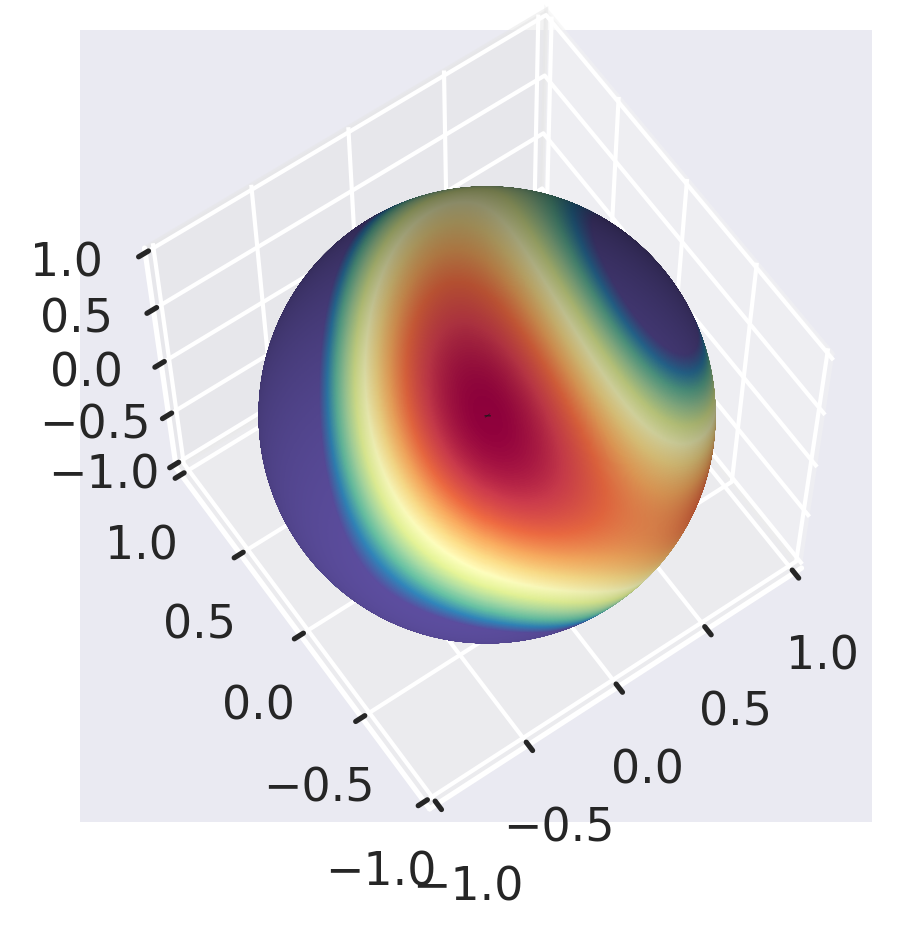

In [6]:
#Set colours and render
fcolors = color_val(val)
fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111, projection='3d')
sb.set_theme()
sb.set_context("notebook")
sb.set_style("darkgrid")
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.Spectral_r(fcolors))
ax.scatter(t_1[0], t_1[1], t_1[2],color="k",s=1000)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_aspect("equal")
ax.view_init(90-180*phi[ind]/(np.pi),360*theta[ind]/(2*np.pi))
ax.quiver(t_1[0], t_1[1], t_1[2], t_1[0]+0.001*grad_X(t_1)[0], t_1[1]+0.001*grad_X(t_1)[1], t_1[2]+0.001*grad_X(t_1)[2], color='k', arrow_length_ratio=0.01)
plt.tight_layout()
plt.show()

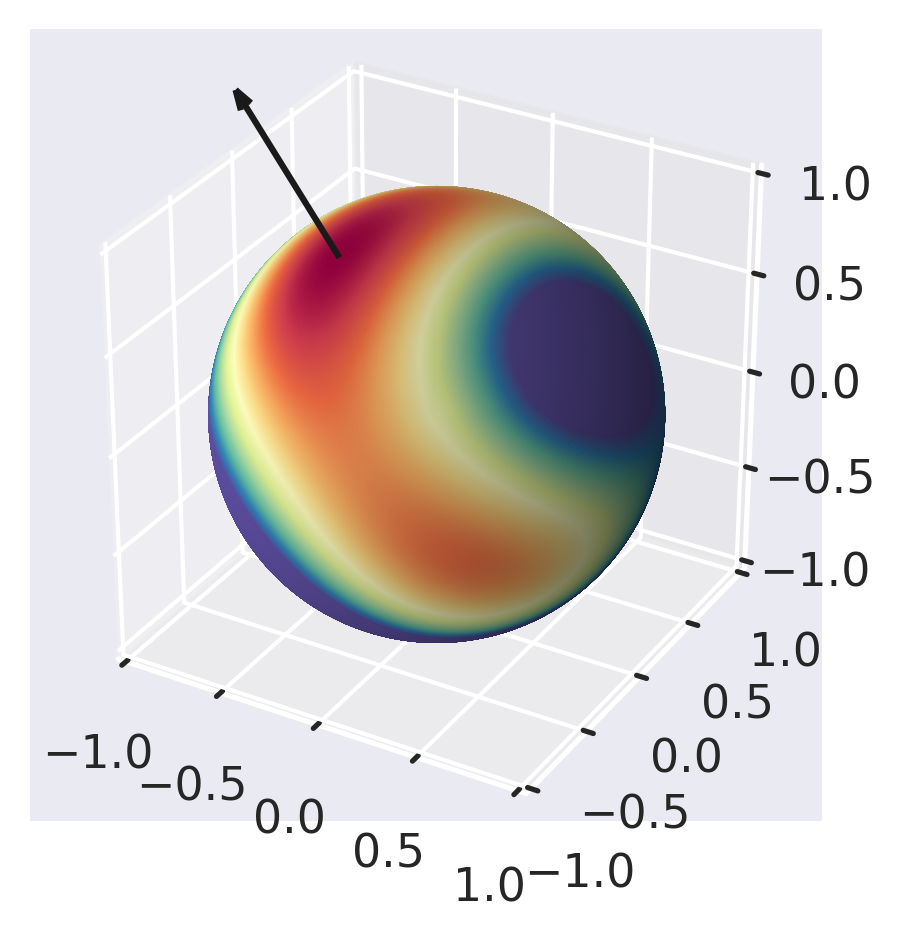

In [7]:
#Set colours and render
fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111, projection='3d')
sb.set_theme()
sb.set_context("notebook")
sb.set_style("darkgrid")
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.Spectral_r(fcolors))
#ax.scatter(t_1[0], t_1[1], t_1[2],color="k",s=1000)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_aspect("equal")
ax.quiver(t_1[0], t_1[1], t_1[2], t_1[0]+0.0001*grad_X(t_1)[0], t_1[1]+0.0001*grad_X(t_1)[1], t_1[2]+0.0001*grad_X(t_1)[2], color='k', arrow_length_ratio=0.1)
plt.tight_layout()
plt.show()

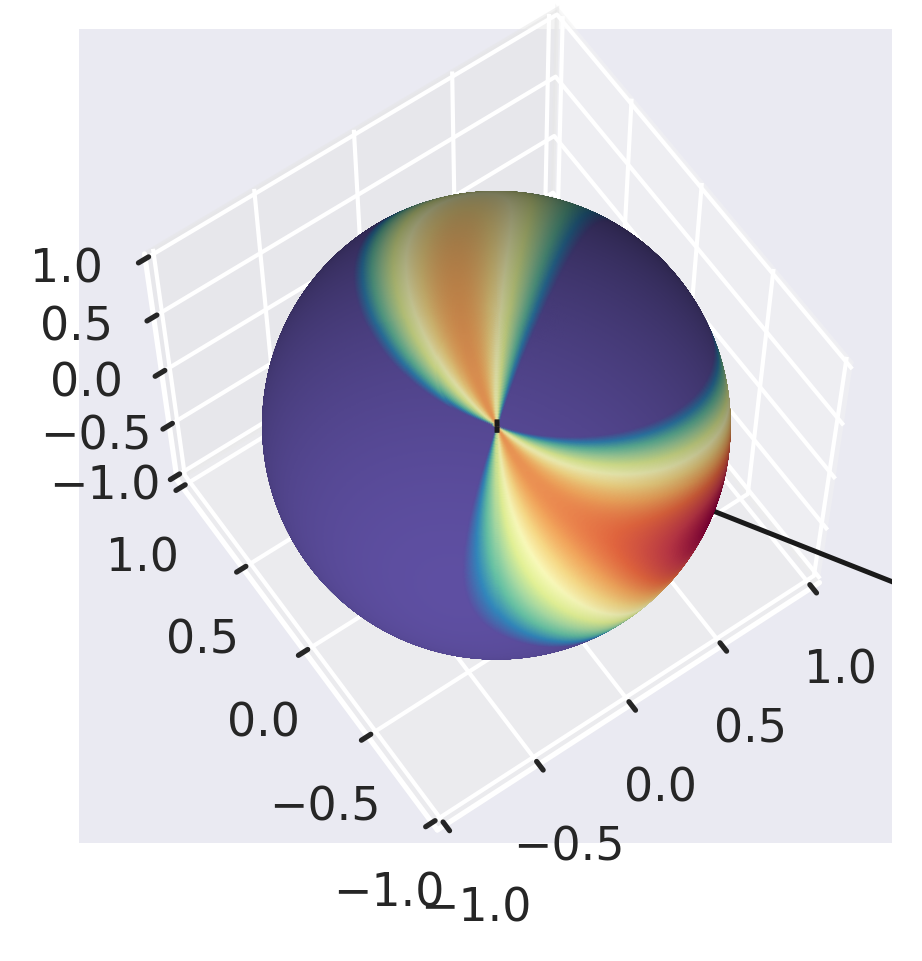

In [8]:
# Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
fcolors = color_val(val2)

#Set colours and render
fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111, projection='3d')
sb.set_theme()
sb.set_context("paper")
sb.set_style("darkgrid")
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.Spectral_r(fcolors))
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_aspect("equal")
ax.view_init(90-180*phi[ind]/(np.pi),360*theta[ind]/(2*np.pi))
ax.quiver(t_1[0], t_1[1], t_1[2], t_1[0]+0.001*grad_X(t_1)[0], t_1[1]+0.001*grad_X(t_1)[1], t_1[2]+0.001*grad_X(t_1)[2], color='k', arrow_length_ratio=0.1)
ax.quiver(t_2[0], t_2[1], t_2[2], t_2[0]+0.001*grad_X2(t_2)[0], t_2[1]+0.001*grad_X2(t_2)[1], t_2[2]+0.001*grad_X2(t_2)[2], color='k', arrow_length_ratio=0.1)
plt.tight_layout()
plt.show()

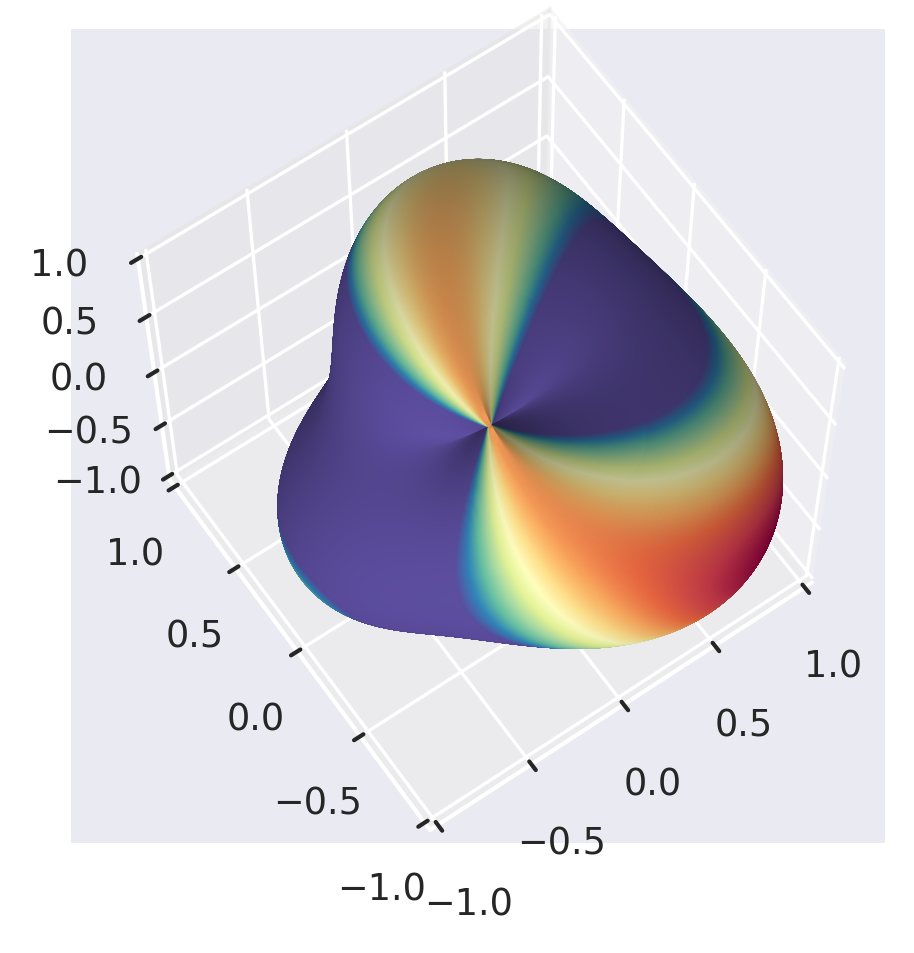

In [9]:
#Set colours and render
fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111, projection='3d')
sb.set_theme()
sb.set_context("paper")
sb.set_style("darkgrid")
ax.plot_surface((1+0.3*val2/lambda_2)*x, (1+0.3*val2/lambda_2)*y, (1+0.3*val2/lambda_2)*z,  rstride=1, cstride=1, facecolors=cm.Spectral_r(fcolors))
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_aspect("equal")
ax.view_init(90-180*phi[ind]/(np.pi),360*theta[ind]/(2*np.pi))
plt.tight_layout()
plt.show()

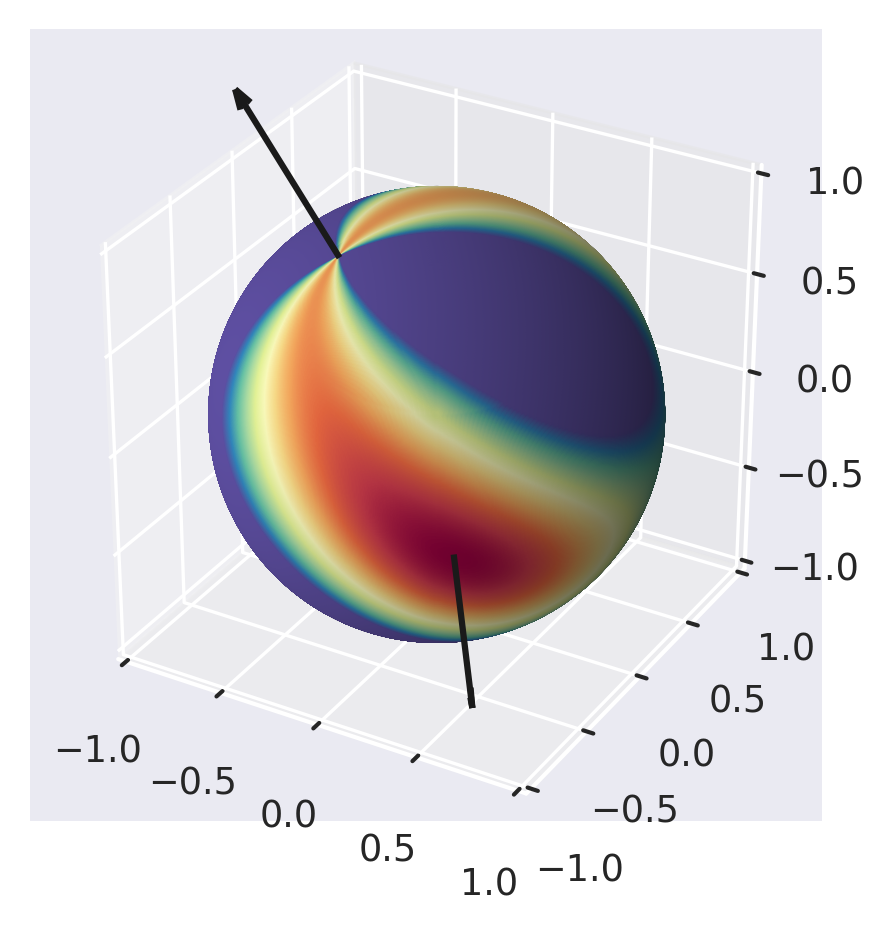

In [10]:
#Set colours and render
fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111, projection='3d')
sb.set_theme()
sb.set_context("notebook")
sb.set_style("darkgrid")
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.Spectral_r(fcolors))
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_aspect("equal")
ax.quiver(t_1[0], t_1[1], t_1[2], t_1[0]+0.001*grad_X(t_1)[0], t_1[1]+0.001*grad_X(t_1)[1], t_1[2]+0.001*grad_X(t_1)[2], color='k', arrow_length_ratio=0.1)
ax.quiver(t_2[0], t_2[1], t_2[2], t_2[0]+0.001*grad_X2(t_2)[0], t_2[1]+0.001*grad_X2(t_2)[1], t_2[2]+0.001*grad_X2(t_2)[2], color='k', arrow_length_ratio=0.1)
plt.tight_layout()
plt.show()

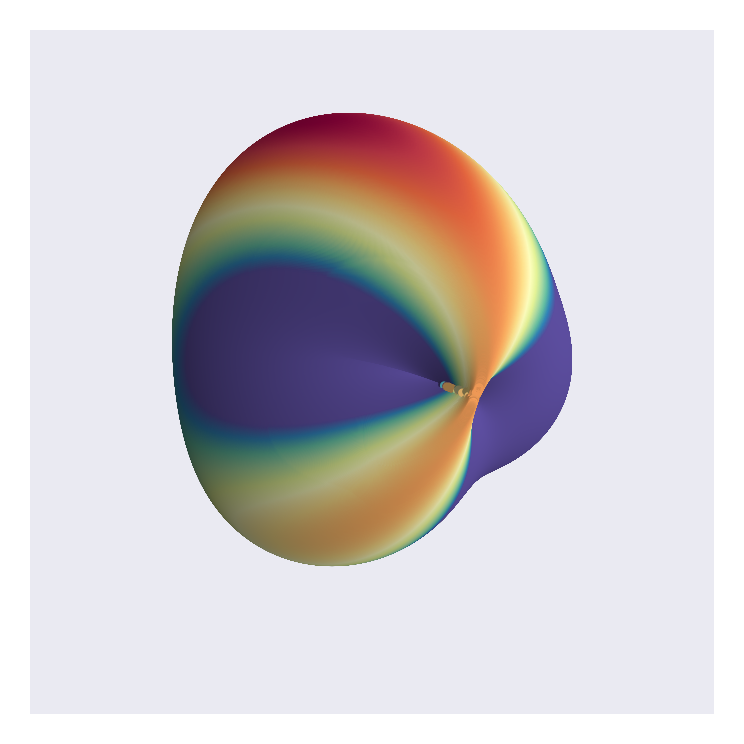

In [11]:
#Set colours and render
fig = plt.figure(figsize = (3, 3))

ax = fig.add_subplot(111, projection='3d')
sb.set_theme()
sb.set_context("poster")
sb.set_style("white")
ax.plot_surface((1+0.3*val2/lambda_2)*x, (1+0.3*val2/lambda_2)*y, (1+0.3*val2/lambda_2)*z,  rstride=1, cstride=1, facecolors=cm.Spectral_r(fcolors))
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_aspect("equal")
ax.set_aspect("equal")
ax.view_init(115,110)
plt.axis('off')
plt.tight_layout()
plt.show()

# Monte-Carlo experiments confirming our findings

In [12]:
# Seed for reproducibility
np.random.seed(seed=31415)

# usefull distributions (chi2)
rv3= chi2(7)

blabla

In [13]:
# Number of MC estimates
repet = 512

# Spacing test p-values
stat = np.zeros(repet)

# t-Spacing test p-values
stat2 = np.zeros(repet)

# standard error estimates
sigma = np.zeros(repet)

# distance to true eigenvector (for 1-sparse alternatives)
dist = np.zeros(repet)

# distance to first estimated eignevector
dist2 = np.zeros(repet)

# random points for variance estimates
V = np.zeros(3*m_bar).reshape((3,m_bar))

# Variance-covariance matrix of regressed random field at the random points
Sigma = np.zeros(m_bar**2).reshape((m_bar,m_bar))



We are given a random symmetric tensor $\mathbf{Y}$ such that
$$\mathbb E[\mathbf{Y}]=\lambda_0 \mathbf{t_0}^{\otimes 3}$$

In [14]:
# alternative
lambda_0 = 0
x_0 = 0
y_0 = 0
z_0 = 1
t_0 = np.array([x_0,y_0,z_0]) #eigenvector

blabla

In [15]:
# Grid on the sphere with 'res' points
res = 512

# angles of the mesh
phi = np.linspace(0, np.pi, res)
theta = np.linspace(0, 2*np.pi, res)
phi, theta = np.meshgrid(phi, theta)

# The Cartesian coordinates of the unit sphere
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

blabla

In [16]:
# Gradient descent parameters to find the maximum of the Random Field
step_size = 0.1
step_count = 256

gros blabla

In [17]:
def cdf_dist_null(z):
    angle = np.arccos(z)
    primitive = (1-np.cos(angle))/2
    return primitive

def scalar_prod(u,v):
    return np.dot(np.transpose(u),v)

for k in tqdm(range(repet), desc="MC samples", leave=False, colour='green'):
    # Gaussian vector
    r = norm.rvs(size=m);
    # Gaussian tensor
    W = np.ones(27).reshape((3,3,3));
    # diagonal
    # principal
    W[0,0,0]=r[0]+lambda_0*x_0*x_0*x_0;
    W[1,1,1]=r[1]+lambda_0*y_0*y_0*y_0;
    W[2,2,2]=r[2]+lambda_0*z_0*z_0*z_0;
    # sub-diag
    W[0,0,1]=r[3]/np.sqrt(3)+lambda_0*x_0*x_0*y_0;
    W[0,1,0]=r[3]/np.sqrt(3)+lambda_0*x_0*x_0*y_0;
    W[1,0,0]=r[3]/np.sqrt(3)+lambda_0*x_0*x_0*y_0;
    W[0,0,2]=r[4]/np.sqrt(3)+lambda_0*x_0*x_0*z_0;
    W[0,2,0]=r[4]/np.sqrt(3)+lambda_0*x_0*x_0*z_0;
    W[2,0,0]=r[4]/np.sqrt(3)+lambda_0*x_0*x_0*z_0;
    W[1,1,0]=r[5]/np.sqrt(3)+lambda_0*y_0*y_0*x_0;
    W[1,0,1]=r[5]/np.sqrt(3)+lambda_0*y_0*y_0*x_0;
    W[0,1,1]=r[5]/np.sqrt(3)+lambda_0*y_0*y_0*x_0;
    W[1,1,2]=r[6]/np.sqrt(3)+lambda_0*y_0*y_0*z_0;
    W[1,2,1]=r[6]/np.sqrt(3)+lambda_0*y_0*y_0*z_0;
    W[2,1,1]=r[6]/np.sqrt(3)+lambda_0*y_0*y_0*z_0;
    W[2,2,0]=r[7]/np.sqrt(3)+lambda_0*z_0*z_0*x_0;
    W[2,0,2]=r[7]/np.sqrt(3)+lambda_0*z_0*z_0*x_0;
    W[0,2,2]=r[7]/np.sqrt(3)+lambda_0*z_0*z_0*x_0;
    W[2,2,1]=r[8]/np.sqrt(3)+lambda_0*z_0*z_0*y_0;
    W[2,1,2]=r[8]/np.sqrt(3)+lambda_0*z_0*z_0*y_0;
    W[1,2,2]=r[8]/np.sqrt(3)+lambda_0*z_0*z_0*y_0;
    # off-diag
    W[0,1,2]=r[9]/np.sqrt(6)+lambda_0*x_0*y_0*z_0;
    W[0,2,1]=r[9]/np.sqrt(6)+lambda_0*x_0*y_0*z_0;
    W[1,0,2]=r[9]/np.sqrt(6)+lambda_0*x_0*y_0*z_0;
    W[1,2,0]=r[9]/np.sqrt(6)+lambda_0*x_0*y_0*z_0;
    W[2,1,0]=r[9]/np.sqrt(6)+lambda_0*x_0*y_0*z_0;
    W[2,0,1]=r[9]/np.sqrt(6)+lambda_0*x_0*y_0*z_0;
    # values of the grid
    val =   W[0,0,0]*(x**3) + W[1,1,1]*(y**3) + W[2,2,2]*(z**3)
    val +=  6*W[0,1,2]*(x*y*z)
    val +=  3*(W[0,0,1]*(x**2*y) + W[0,0,2]*(x**2*z) + W[1,1,0]*(y**2*x) + W[1,1,2]*(y**2*z) + W[2,2,0]*(z**2*x) + W[2,2,1]*(z**2*y))
    # maximum on the grid
    ind = np.unravel_index(np.argmax(val, axis=None), val.shape)
    t_1 = np.array([np.sin(phi[ind]) * np.cos(theta[ind]), np.sin(phi[ind]) * np.sin(theta[ind]), np.cos(phi[ind])]).reshape((3,1))
    t_1_grid = t_1
    # Random Field X
    def X(t):
        X_val = W[0,0,0]*(t[0]**3) + W[1,1,1]*(t[1]**3) + W[2,2,2]*(t[2]**3);
        X_val += 6*W[0,1,2]*(t[0]*t[1]*t[2]);
        X_val += 3*(W[0,0,1]*(t[0]**2*t[1]) + W[0,0,2]*(t[0]**2*t[2]) + W[1,1,0]*(t[1]**2*t[0]) + W[1,1,2]*(t[1]**2*t[2]) + W[2,2,0]*(t[2]**2*t[0]) + W[2,2,1]*(t[2]**2*t[1]));
        return X_val

    def grad_X(t):
        gradient_val = np.zeros(3)
        gradient_val[0] = 6*(W[0,1,2]*t[1]*t[2]+W[0,0,2]*t[0]*t[2]+W[0,0,1]*t[0]*t[1]) + 3*(W[0,0,0]*t[0]**2+W[0,1,1]*t[1]**2+W[0,2,2]*t[2]**2)
        gradient_val[1] = 6*(W[1,1,2]*t[1]*t[2]+W[1,0,2]*t[0]*t[2]+W[1,0,1]*t[0]*t[1]) + 3*(W[1,0,0]*t[0]**2+W[1,1,1]*t[1]**2+W[1,2,2]*t[2]**2)
        gradient_val[2] = 6*(W[2,1,2]*t[1]*t[2]+W[2,0,2]*t[0]*t[2]+W[2,0,1]*t[0]*t[1]) + 3*(W[2,0,0]*t[0]**2+W[2,1,1]*t[1]**2+W[2,2,2]*t[2]**2)
        return gradient_val

    def grad_riem_X(t):
        Pi = np.dot(t,np.transpose(t))
        temp = np.dot((np.eye(3)-Pi),grad_X(t))
        return temp

    egrad_X = egrad(X)

    def Hess_X(t):
        H = np.zeros(9).reshape((3,3));
        for i in [0,1,2]:
            for j in [0,1,2]:
                H[i,j]=6*(W[i,j,0]*t[0]+W[i,j,1]*t[1]+W[i,j,2]*t[2]);
        return H

    def Hess_riem_X(u):
        Pi = np.dot(u,np.transpose(u))
        R = np.dot((np.eye(3)-Pi),Hess_X(u))
        R = np.dot(R,(np.eye(3)-Pi))
        R -= np.dot(np.transpose(grad_X(u)),u)*(np.eye(3)-Pi)
        return R

    # GD on the sphere to find the maximum
    for i in range(step_count):
        Pi = np.dot(t_1,np.transpose(t_1));
        gradient = np.dot((np.eye(3)-Pi),egrad_X(t_1));
        t_temp = t_1 + step_size * gradient;
        t_1 = t_temp/np.linalg.norm(t_temp);

    lambda_1 = X(t_1)
    dist[k] = np.dot(np.transpose(t_1),t_0)

    #Projection
    Pi = np.dot(t_1,np.transpose(t_1))
    # Hessian
    R = Hess_riem_X(t_1)
    R = (1/3)*R+lambda_1*(np.eye(3)-Pi)
    R += Pi
    # det and trace of R
    detR = np.linalg.det(R)
    traceR = np.matrix.trace(R)-1

    def G(l):
        output = 0
        output += (l-traceR)*norm.pdf(l)
        output += (detR+1)*(1-norm.cdf(l))
        return output

    def H(l):
        output = detR*(np.sqrt(7/9)*(1-rv.cdf(l*np.sqrt(9)/np.sqrt(7))))
        output += (-traceR)*((7*np.sqrt(7))/(8*np.sqrt(9)))*((gamma(5)*gamma(7/2))/(gamma(9/2)*gamma(4)))*rv2.pdf(l)
        output += ((7*np.sqrt(7))/(8*np.sqrt(9)))*((gamma(5)*gamma(7/2))/(gamma(9/2)*gamma(4)))*(l*rv2.pdf(l)+1-rv2.cdf(l))
        return output

    G1= G(lambda_1)

    #Regressed random field
    def X2(u):
        cst = np.dot(np.transpose(t_1),u)**3
        X_val = X(u)-cst*X(t_1);
        X_val =  X_val/(1-cst);
        return X_val

    grad_X2 = egrad(X2)

    cst_val = (t_1[0]*x+t_1[1]*y+t_1[2]*z)**3
    val2 = val -  cst_val* X(t_1)
    val2 = val2/(1-cst_val)


    ind2 = np.unravel_index(np.argmax(val2, axis=None), val.shape)
    t_2 = np.array([np.sin(phi[ind2]) * np.cos(theta[ind2]), np.sin(phi[ind2]) * np.sin(theta[ind2]), np.cos(phi[ind2])]).reshape((3,1))
    t_2_grid = t_2

    for i in range(step_count):
        Pi = np.dot(t_2,np.transpose(t_2));
        gradient = np.dot((np.eye(3)-Pi),grad_X2(t_2));
        t_temp = t_2 + step_size * gradient;
        t_2 = t_temp/np.linalg.norm(t_temp);

    lambda_2 = X2(t_2)

    dist2[k]=np.dot(np.transpose(t_1),t_2)

    G2= G(lambda_2)

    stat[k] = G1/G2


    Pi = np.dot(t_1,np.transpose(t_1))


    for i in range(m_bar):
        r = norm.rvs(size=3)
        r = r/np.linalg.norm(r)
        V[:,i] = r

    for i in range(m_bar):
        u = V[:,i]
        for j in range(m_bar):
            v = V[:,j]
            Sigma[i,j] = scalar_prod(u,v)**3 - (scalar_prod(u,t_1)**3)*(scalar_prod(v,t_1)**3) - (1/3)*scalar_prod((3*(scalar_prod(u, t_1)**2)*np.dot((np.eye(3)-Pi),u)),(3*(scalar_prod(v, t_1)**2)*np.dot((np.eye(3)-Pi),v)))

    X2_V = np.zeros(m_bar)

    def X22(u):
        cst = np.dot(np.transpose(t_1),u)**3
        X_val = X(u)-cst*X(t_1);
        return X_val

    for i in range(m_bar):
        X2_V[i] = X22(V[:,i])


    eig, eigvec = np.linalg.eig(Sigma)
    Sigma12 = eigvec*(1/np.sqrt(eig))
    Sigma12 = np.dot(Sigma12,np.transpose(eigvec))
    sigmahat = (np.linalg.norm(np.dot(Sigma12,X2_V))**2)/m_bar

    sigma[k] = np.sqrt(sigmahat)

    stat2[k] = H(lambda_1/np.sqrt(sigmahat))/H(lambda_2/np.sqrt(sigmahat))

blabla

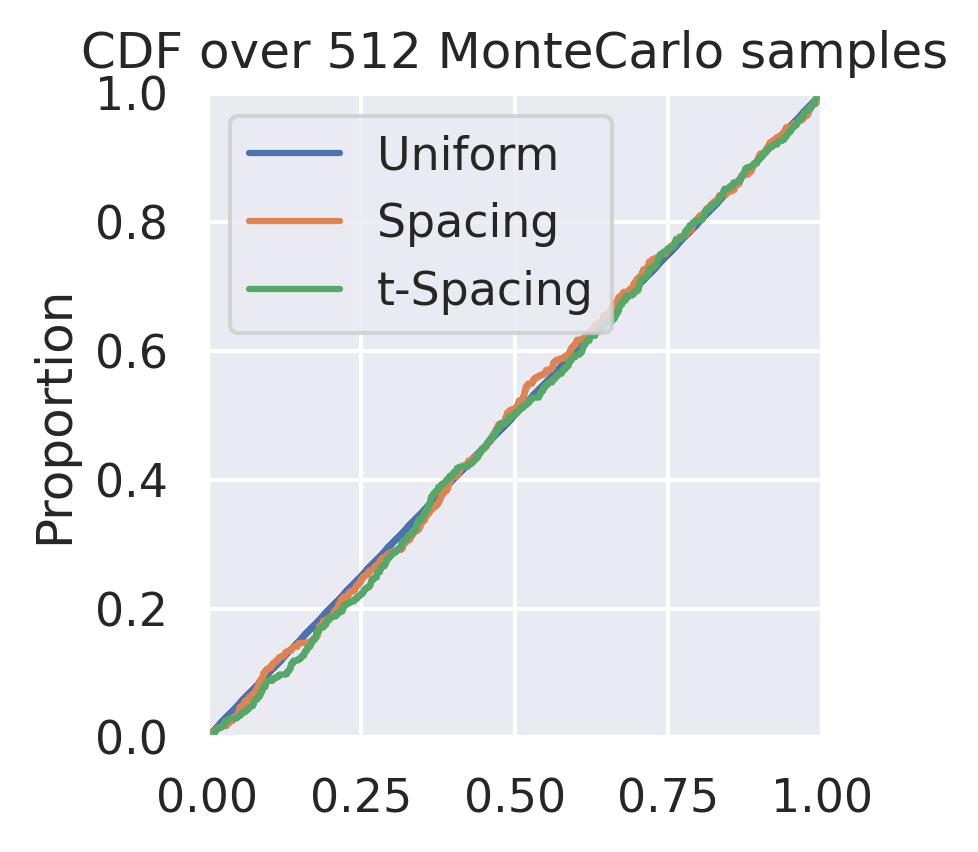

In [18]:
unif = np.linspace(0, 1, 10*repet)
fig = plt.figure(figsize = (3, 3))
sb.set_theme()
sb.set_context("notebook")
sb.set_style("darkgrid")
sb.ecdfplot(unif)
sb.ecdfplot(stat)
sb.ecdfplot(stat2)
plt.legend(["Uniform", "Spacing", "t-Spacing"])
plt.title ("CDF over %s MonteCarlo samples" %(repet))
plt.tight_layout()
plt.ylim((0,1))
plt.xlim((0,1))
plt.show()

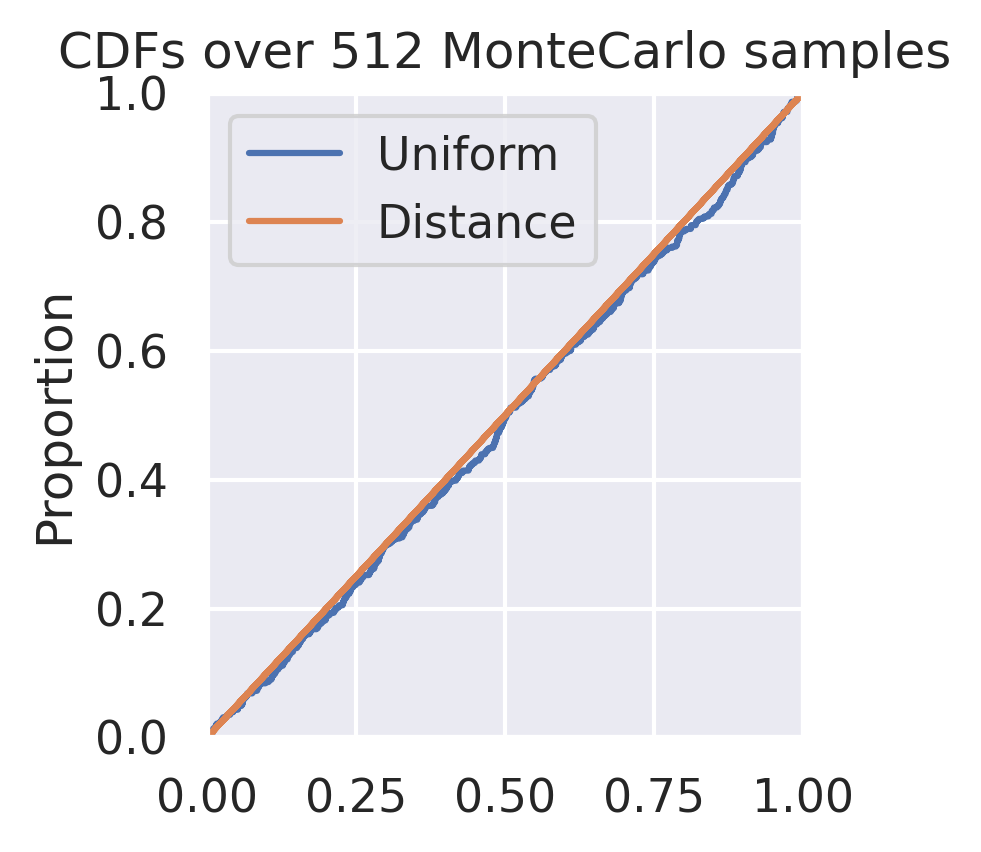

In [19]:
unif_dist = cdf_dist_null(dist)
unif_dist2 = cdf_dist_null(dist2)
fig = plt.figure(figsize = (3, 3))
sb.set_theme()
sb.set_context("notebook")
sb.set_style("darkgrid")
sb.ecdfplot(unif_dist)
sb.ecdfplot(unif)
plt.legend(["Uniform", "Distance"])
plt.title ("CDFs over %s MonteCarlo samples" %(repet))
plt.tight_layout()
plt.ylim((0,1))
plt.xlim((0,1))
plt.show()


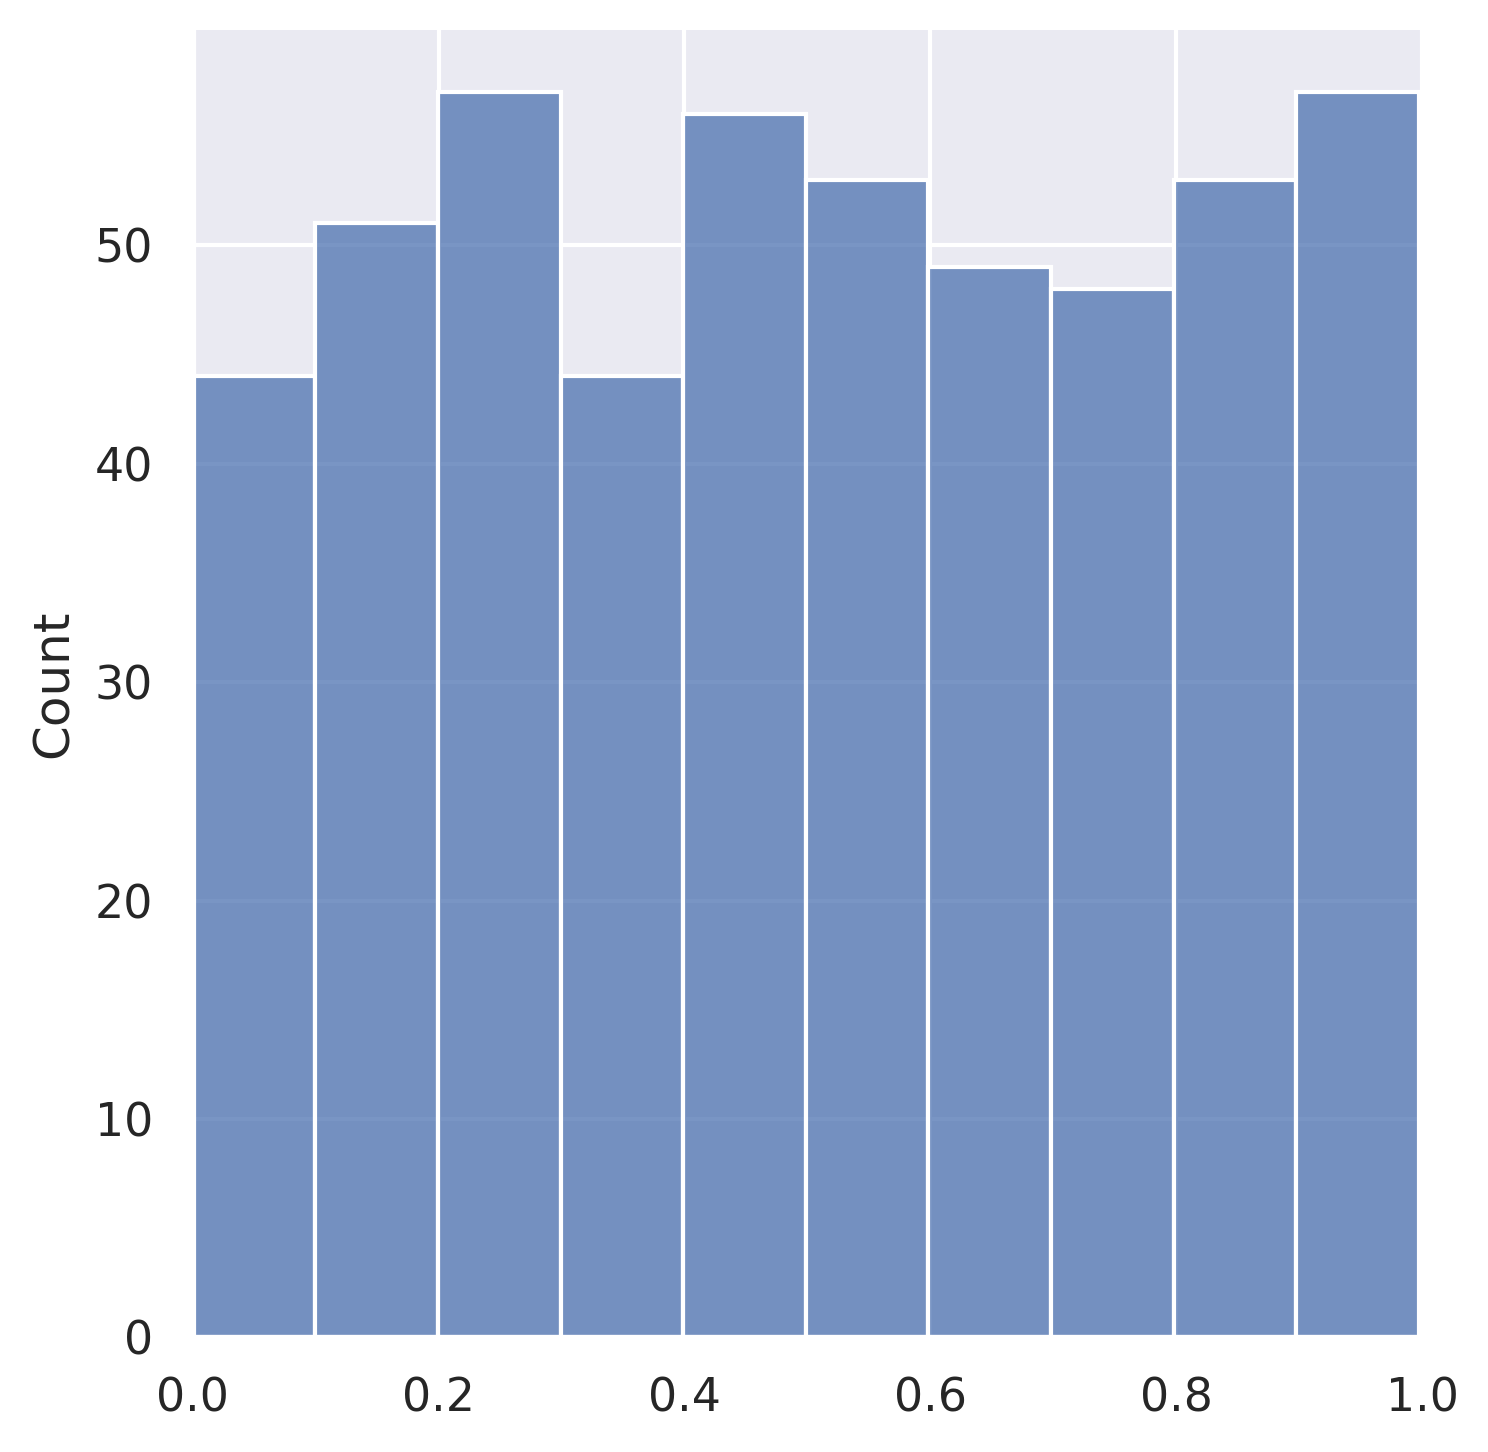

In [20]:
sb.set_theme()
sb.set_context("notebook")
sb.set_style("darkgrid")
sb.displot(unif_dist)
plt.tight_layout()
plt.xlim((0,1))
plt.show()


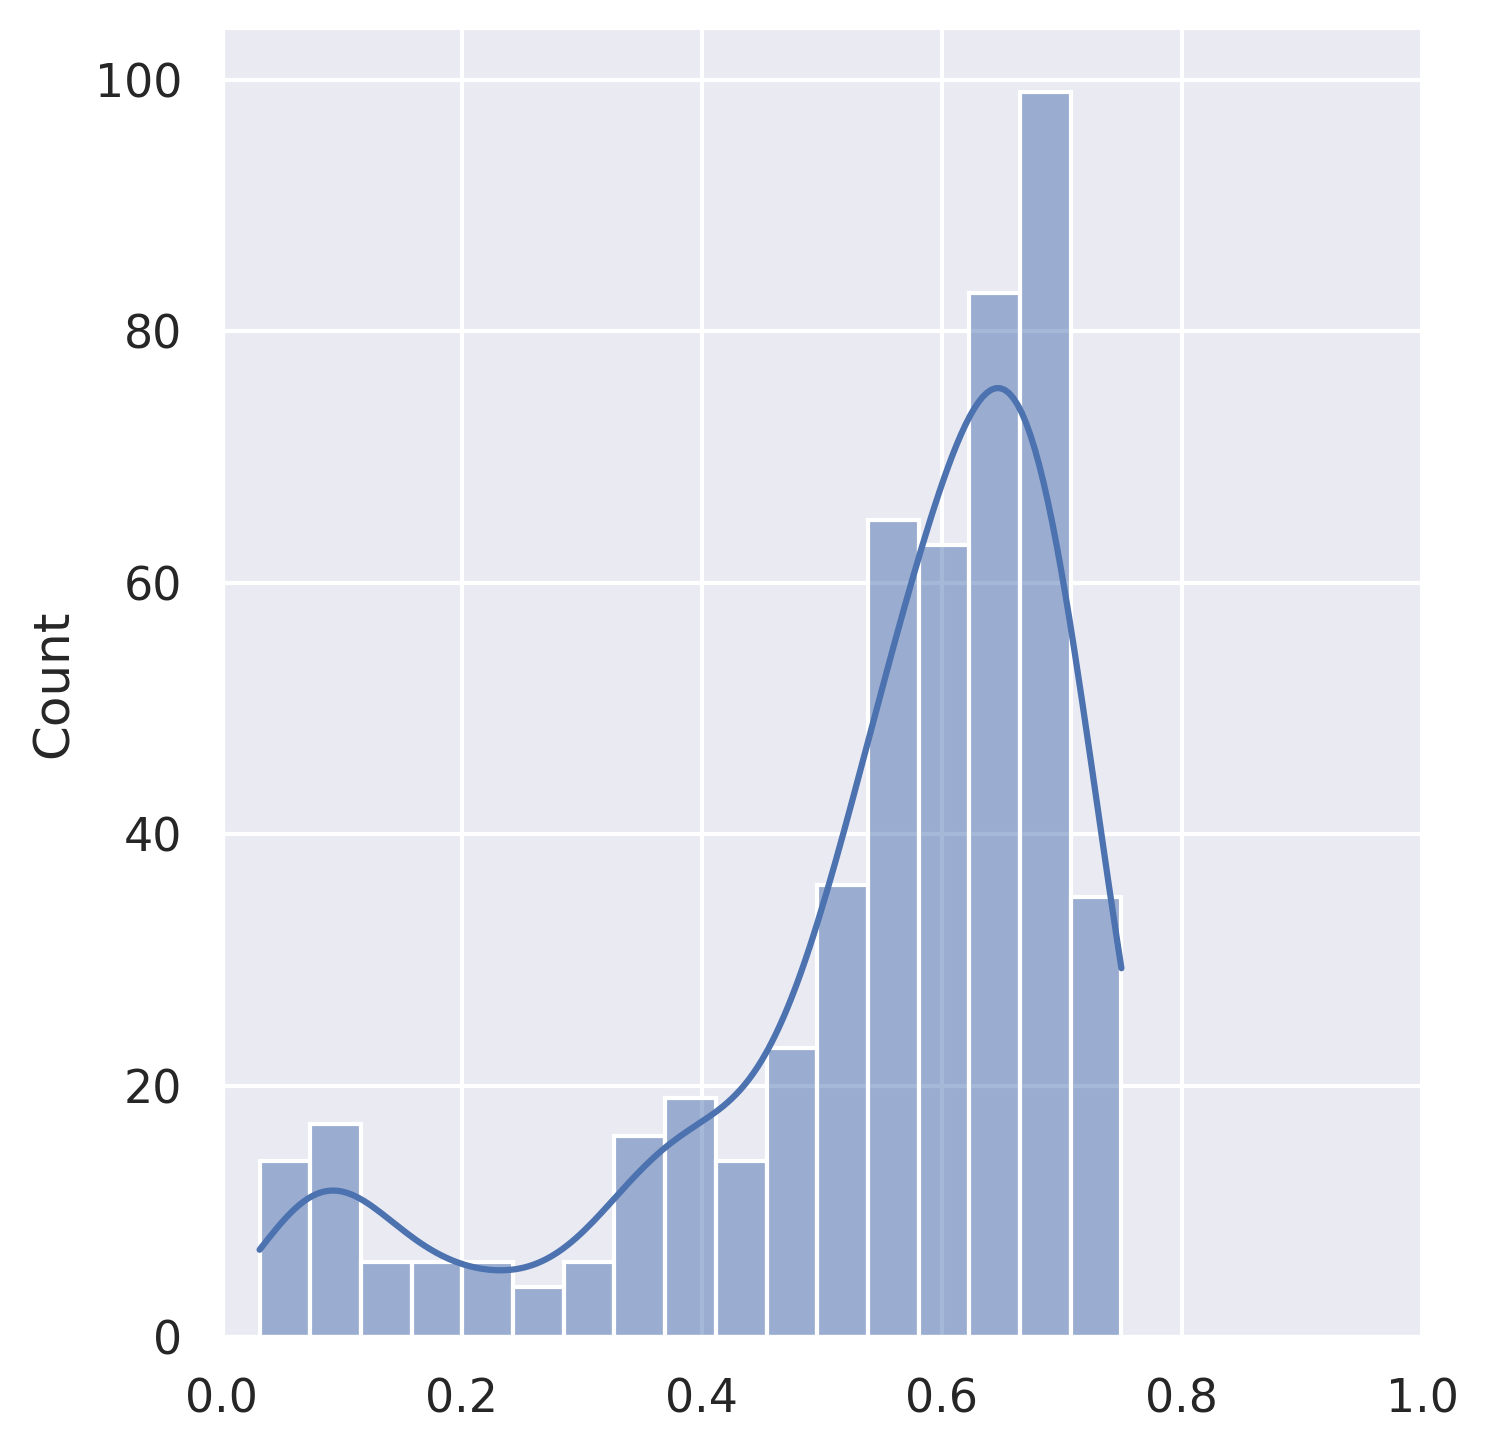

In [21]:

sb.set_theme()
sb.set_context("notebook")
sb.set_style("darkgrid")
sb.displot(unif_dist2, kde=True)
plt.tight_layout()
plt.xlim((0,1))
plt.show()